- *It works!*
- DONE: use `max_batchsize` from `utils`
- DONE: make **dedicated notebook** to (i) compare `conll2003` to `fewnerd` and (ii) to bring `fewnerd` into the same format.
- DONE: use fewnerd
- DONE: get total flops count with **einops**
- DONE: make custom splits
- DONE: reorder the notebook cells:
  - DONE: model (LoRA) and tokenizer (save peftconfig if necessary)
  - DONE: dataset etc
  - DONE: training, metrics and saving (tokenizer and model)
  - DONE: inference via loading saved items (probably tokenizer, model and peftconfig – OR follow this [guide](https://huggingface.co/docs/peft/v0.9.0/en/package_reference/lora#peft.LoraModel))
- DONE: In **Using the fine-tuned model**, [merge and unload](https://huggingface.co/docs/peft/v0.6.2/en/package_reference/tuners#peft.LoraModel.merge_and_unload) or [reinstantiate](https://huggingface.co/docs/peft/v0.6.2/en/task_guides/token-classification-lora#inference) the LoRA model!
- DONE: adjust batch size – and if necessary epochs – for 3000 training steps `num_steps = train_instances*epochs/batch_size` $\geq$ 3000 $\Rightarrow$ `batch_size` $\leq$ `train_instances*epochs/3000 = train_instances/1000` $\Rightarrow$ `batch_size` $\leq$ `train_instances / 1000` for `epochs = 3`<br>DONE: But do it like this:
  - DONE: get max batch size for model (= max_batchsize_by_model)
  - DONE: specify trainig split
  - DONE: get max batch size for training split length (=max_batchsize_by_trainsplit)
  - DONE: impose max batch size of 32
  - DONE: the batch size is the minimum of these three numbers
- DONE: build `results.json` (consider pandas series) via dict. It holds: splits, specified loraconfig details, flops, metrics (per epoch)
- DONE: use the uuid library to save `results.json` under `results_{uuid}.json`
- DONE: declare variable `split` and use it to select splits as well as for logging it in `results_{uuid}.json`.
- DONE: use split `dev` and determine the learning rate for LoRA models. It seems that with `accelerate`, the maximum accepted learning rate is `5e-4` since fails for higher learning rates.
- DONE: outside the training loop make a dummy classification report using scikit-learn with dummy labels and dummy predictions (both formatted as required by classification report)
- DONE: at the end of each epoch, bring the labels and predictions into the required format
- DONE: write a compute metrics function that returns a [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report) as dict, then log the relevant values
- DONE: drop the `uuid` from the `logs_dict` filename as it only adds ambiguity about what file to look at.
- DONE: Use both `macro` and `weighted` metrics.
- DONE: Specify `output_dir` with `spec` (e.g. `ner_logs/fb-roberta/{spec}`) for saving `logs_dict.json` and `confusion_matrix.png`:
  - DONE: pattern: `task/model/spec/*files_with_vanilla_names*`
  - DONE: example: `ner_logs/FacebookAI-roberta-large/split=dev__r=64__bias=lora_only__loradroput=0point2/logs_dict.json`
- DONE: Add confusion matrix
  - DONE: save percentage version
  - DONE: save vanilla version
- DONE: Save `logs_dict.json` and `confusion_matrix.png`.
- DONE: keep original ner labels (IOB2 would result in 2*n-1 labels instead of n labels – but due to sparse labels, the dataset is already difficult enough)
- DONE: filter out long instances with 80 words or more $\Rightarrow$ remove 0.3384% of training instances (negligible).
- Drop accelerate and use basic torch loop as in `roberta-base-ner_LoRA_cells.ipynb` (make a copy of that other notebook and adapt it to this one.
- Pick a not too long instance from `fewnerd_all_processed` and show token - label pairs (as for inference).
- Handle and log both `roberta-large` and `roberta-base` (adapt `batch_size_dict`).
- Check once more the wandb [ablation study](https://wandb.ai/ayush-thakur/dl-question-bank/reports/What-s-the-Optimal-Batch-Size-to-Train-a-Neural-Network---VmlldzoyMDkyNDU) on batch sizes!
- check everything once more
- add comments
- make new notebook copy for sweep

# NER with `fewnerd` and LoRA

In [1]:
%matplotlib inline
import re
import json
import time
import torch
import datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt

from peft import LoraConfig, TaskType, PeftModel, PeftConfig, get_peft_model, prepare_model_for_kbit_training
from utils import set_seed, smoothen_list, make_confusion_matrix
from datasets import load_dataset, concatenate_datasets, DatasetDict
from evaluate import load
from tqdm.auto import tqdm
from accelerate import Accelerator
from torch.optim import AdamW
from transformers import get_scheduler, pipeline, AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification
from huggingface_hub import login
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from deepspeed.profiling.flops_profiler import FlopsProfiler

logs_dict = {}
logs_dict["seed"] = set_seed(42)

[2024-04-23 18:35:07,472] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)
All random seeds set to 42.


## Model

In [2]:
raw_datasets = load_dataset("DFKI-SLT/few-nerd", "supervised")
ner_feature = raw_datasets["train"].features["ner_tags"]
label_names = ner_feature.feature.names
print(label_names)
id2label = {str(i): label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}
id2label, label2id

['O', 'art', 'building', 'event', 'location', 'organization', 'other', 'person', 'product']


({'0': 'O',
  '1': 'art',
  '2': 'building',
  '3': 'event',
  '4': 'location',
  '5': 'organization',
  '6': 'other',
  '7': 'person',
  '8': 'product'},
 {'O': '0',
  'art': '1',
  'building': '2',
  'event': '3',
  'location': '4',
  'organization': '5',
  'other': '6',
  'person': '7',
  'product': '8'})

In [3]:
model_version = "large" # "base" or "large"
model_id = f"FacebookAI/roberta-{model_version}"
logs_dict["model_id"] = model_id
model = AutoModelForTokenClassification.from_pretrained(
    model_id,
    id2label=id2label,
    label2id=label2id,
    device_map="auto",
    load_in_8bit=True
)
# LoRA model
# datasets:     3 values [1%, 10%, 100%]
# lora_rank:   10 values [1, ..., 512]
# lora_dropout: 5 values [0, 0.1, 0.2, 0.3, 0.4]
# lora_bias:    3 values ["all", "none", "lora_only"]
# => 3 x 8 x 5 x 3 = 360 sweeps per notebook (of which 45 have rank 128)
# => start with 2 dataset values (10%, 100%) and 3 rank values (2, 8, 32) => 6 sweeps
LoRA_params_dict = {
    "r": 16,
    "target_modules": ["query", "key", "value", "query_proj", "key_proj", "value_proj"],
    "bias": "all",
    "use_rslora": True,
    "task_type": TaskType.TOKEN_CLS,
    "lora_dropout": 0.2
}
logs_dict["LoRA_params_dict"] = LoRA_params_dict
config = LoraConfig(
    # GUIDE   => https://huggingface.co/docs/peft/main/en/conceptual_guides/lora#common-lora-parameters-in-peft
    # https://huggingface.co/docs/peft/main/en/conceptual_guides/lora#common-lora-parameters-in-peft:~:text=use_rslora%3A%20When%20set%20to%20True%2C%20uses%20Rank%2DStabilized%20LoRA%20which%20sets%20the%20adapter%20scaling%20factor
    # https://arxiv.org/abs/2312.03732, 
    r = LoRA_params_dict["r"],
    target_modules=LoRA_params_dict["target_modules"],
    bias=LoRA_params_dict["bias"],
    use_rslora=LoRA_params_dict["use_rslora"],
    task_type=LoRA_params_dict["task_type"],
    lora_dropout=LoRA_params_dict["lora_dropout"]
)
logs_dict["LoraConfig"] = str(config)
print(f"LoRA config:\n{config}\n")
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, config)
print(f"base_model type:\n{type(model)}")
print(f"\nadapter_model type:\n{type(model)}")
trainable_params, all_params = model.get_nb_trainable_parameters()
trainable_fraction = round(trainable_params/all_params, 5)
logs_dict["LoRA_model_trainable_params"] = trainable_params
logs_dict["LoRA_model_all_params"] = all_params
logs_dict["LoRA_model_trainable_fraction"] = trainable_fraction
print(f"\ntrainable parameters:\n{trainable_params}")
print(f"\nall parameters:\n{all_params}")
print(f"\ntrainable fraction:\n{trainable_fraction}")

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA config:
LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=<TaskType.TOKEN_CLS: 'TOKEN_CLS'>, inference_mode=False, r=16, target_modules={'query_proj', 'key', 'query', 'value_proj', 'value', 'key_proj'}, lora_alpha=8, lora_dropout=0.2, fan_in_fan_out=False, bias='all', use_rslora=True, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={})

base_model type:
<class 'peft.peft_model.PeftModelForTokenClassification'>

adapter_model type:
<class 'peft.peft_model.PeftModelForTokenClassification'>

trainable parameters:
2639881

all parameters:
356687890

trainable fraction:
0.0074


In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_id, add_prefix_space=True)
logs_dict["tokenizer"] = model_id
print(f"tokenizer is fast: {tokenizer.is_fast}")
tokenizer

tokenizer is fast: True


RobertaTokenizerFast(name_or_path='FacebookAI/roberta-large', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

## Dataset

In [5]:
raw_datasets = load_dataset("DFKI-SLT/few-nerd", "supervised")
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'fine_ner_tags'],
        num_rows: 131767
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'fine_ner_tags'],
        num_rows: 18824
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'fine_ner_tags'],
        num_rows: 37648
    })
})

In [6]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # start of a new word
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # special token
            new_labels.append(-100)
        else:
            # same word as previous token
            label = labels[word_id]
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

fewnerd_all_processed = (
    concatenate_datasets([raw_datasets["train"], raw_datasets["validation"], raw_datasets["test"]])
    .filter(lambda example: len(example["tokens"])<=50)
    .map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=raw_datasets["train"].column_names
    )
)
fewnerd_all_processed

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 181338
})

In [7]:
# filter dataset by length if necessary
trainvalid_test_splits = fewnerd_all_processed.train_test_split(test_size=0.15)
test_split_100 = trainvalid_test_splits["test"]
test_split_10 = test_split_100.train_test_split(test_size = 0.1)["test"]
test_split_1 = test_split_100.train_test_split(test_size = 0.01)["test"]
trainvalid_split = trainvalid_test_splits["train"]
train_valid_split = trainvalid_split.train_test_split(test_size=0.15)
valid_split_100 = train_valid_split["test"]
valid_split_10 = valid_split_100.train_test_split(test_size = 0.1)["test"]
valid_split_1 = valid_split_100.train_test_split(test_size = 0.01)["test"]
train_split_100 = train_valid_split["train"]
train_split_10 = train_split_100.train_test_split(test_size = 0.1)["test"]
train_split_1 = train_split_100.train_test_split(test_size = 0.01)["test"]
dev_train_split = train_split_100.train_test_split(test_size = 120)["test"]
dev_valid_split = valid_split_100.train_test_split(test_size = 32)["test"]
dev_test_split = test_split_100.train_test_split(test_size = 8)["test"]
fewnerd_dsd = DatasetDict({
    "train_100": train_split_100,
    "train_10": train_split_10,
    "train_1": train_split_1,
    "valid_100": valid_split_100,
    "valid_10": valid_split_10,
    "valid_1": valid_split_1,
    "test_100": test_split_100,
    "test_10": test_split_10,
    "test_1": test_split_1,
    "train_dev": dev_train_split,
    "valid_dev": dev_valid_split,
    "test_dev": dev_test_split
})
fewnerd_dsd

DatasetDict({
    train_100: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 131016
    })
    train_10: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 13102
    })
    train_1: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1311
    })
    valid_100: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 23121
    })
    valid_10: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2313
    })
    valid_1: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 232
    })
    test_100: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 27201
    })
    test_10: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2721
    })
    test_1: Dataset({
        features: ['input_ids', 'attentio

In [8]:
split = "100" # "100", "10", "1", "dev"
assert split in ("100", "10", "1", "dev"), f"Split '{split}' is not a valid choice."
train_split = f"train_{split}"
valid_split = f"valid_{split}"
test_split = f"test_{split}"
train_split, valid_split, test_split

('train_100', 'valid_100', 'test_100')

In [9]:
spec = f"split={split}"
spec += f"__r={LoRA_params_dict['r']}"
spec += f"__bias={LoRA_params_dict['bias']}"
spec += f"__loradroput=0point{str(LoRA_params_dict['lora_dropout'])[2:]}"
model_folder = re.sub("/", "-", model_id)
output_dir = f"ner_logs/{model_folder}/{spec}"
output_dir

'ner_logs/FacebookAI-roberta-large/split=100__r=16__bias=all__loradroput=0point2'

## Training

In [10]:
batchsize_dict = {
    # batch size rules: (i) as large as possible, (ii) 1000 steps per epoch, (iii) 32 max
    "100": 32,
    "10": 8,
    "1": 1,
    "dev": 2
}
batch_size = batchsize_dict[split]
logs_dict["batch_size"] = batch_size
batch_size

32

In [11]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
data_collator

DataCollatorForTokenClassification(tokenizer=RobertaTokenizerFast(name_or_path='FacebookAI/roberta-large', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pad_to_multipl

In [12]:
batch = data_collator([fewnerd_dsd[train_split][i] for i in [0, 1]])
batch["labels"] # As we can see, the second set of labels has been padded to the length of the first one using -100s.

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[-100,    0,    0,    0,    0,    0,    0,    0,    0,    8,    8,    0,
            0,    0,    6,    0,    0,    0,    0,    0, -100],
        [-100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0, -100, -100, -100, -100, -100, -100, -100, -100]])

In [13]:
train_dataloader = DataLoader(
    fewnerd_dsd[train_split],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size
)
valid_dataloader = DataLoader(fewnerd_dsd[valid_split], collate_fn=data_collator, batch_size=batch_size)
train_dataloader, valid_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x70d15c1fe650>,
 <torch.utils.data.dataloader.DataLoader at 0x70d15c1ffa00>)

In [14]:
optimizer = AdamW(model.parameters(), lr=1e-4)
accelerator = Accelerator()
model, optimizer, train_dataloader, valid_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
    valid_dataloader
)
num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch
logs_dict["num_training_steps"] = num_training_steps
num_warmup_steps = min(500, round(0.15 * num_update_steps_per_epoch)) # 500 or 15% of one epoch, whichever is less
logs_dict["num_warmup_steps"] = num_warmup_steps
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)
print(f"training_steps (all epochs):\t{num_training_steps}\nnum_warmup_steps (first epoch):\t{num_warmup_steps}")

training_steps (all epochs):	12285
num_warmup_steps (first epoch):	500


In [15]:
def flatten_list_of_lists(list_of_lists):
    flattened_list = []
    for list_i in list_of_lists:
        list_i = list_i.tolist() # handle tensors in case list_of_lists is a list of tensors
        list_i = list(itertools.chain.from_iterable(list_i)) # flatten list_i using the standard library
        flattened_list += list_i
    return flattened_list

def compute_metrics(y_true, y_pred, average_type):
    metrics_dict = classification_report(y_true, y_pred, digits=6, output_dict=True, zero_division=0.0)
    accuracy = metrics_dict["accuracy"]
    avg_dict = metrics_dict[average_type]
    avg_dict["accuracy"] = accuracy
    # https://stackoverflow.com/questions/52139110/how-to-change-the-order-of-keys-in-a-python-3-5-dictionary-using-another-list-a
    avg_dict_order = {k : avg_dict[k] for k in ["accuracy", "precision", "recall", "f1-score", "support"]}
    avg_dict_order["support"] = round(avg_dict_order["support"])
    metrics = [f"{key}: {avg_dict_order[key]}" for key in avg_dict_order.keys()]
    return metrics

prof = FlopsProfiler(model) # deepspeed profiler
flops_list = []
loss_list = []
lr_rate_list = []
training_start = True
validation_start = True
progress_bar = tqdm(range(num_training_steps))
start_time = time.time() # start time
for epoch in range(num_train_epochs):
    # Training
    model.train()
    prof.start_profile() # start profiling
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        loss_list.append(loss.item())
        accelerator.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        lr_rate_list.append(lr_scheduler.get_last_lr()[0])
        if training_start:
            print("\ntraining")
            print([f"{key} shape: {list(batch[key].shape)}" for key in list(batch.keys())])
            print(f"logits shape: {list(outputs['logits'].shape)}, loss: {float(outputs['loss'])}\n")
            training_start = False
        optimizer.zero_grad()
        progress_bar.update(1)
    prof.stop_profile() # stop profiling
    total_flops = prof.get_total_flops()
    flops_list.append(total_flops)
    # Validation
    model.eval()
    epoch_predictions = []
    epoch_labels = []
    for batch in valid_dataloader:
        with torch.no_grad():
            outputs = model(**batch)
        if validation_start:
            print("validation")
            print([f"{key} shape: {list(batch[key].shape)}" for key in list(batch.keys())])
            print(f"logits shape: {list(outputs['logits'].shape)}, loss: {float(outputs['loss'])}\n")
            validation_start = False
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        epoch_predictions.append(predictions)
        epoch_labels.append(labels)
    # collect both, labels and predictions, in one big list each
    flat_epoch_labels = flatten_list_of_lists(epoch_labels)
    flat_epoch_predictions = flatten_list_of_lists(epoch_predictions)
    # get classification report, then log and print results
    metrics_macro = compute_metrics(flat_epoch_labels, flat_epoch_predictions, "macro avg")
    metrics_weighted = compute_metrics(flat_epoch_labels, flat_epoch_predictions, "weighted avg")
    logs_dict[f"epoch_{epoch}_metrics_macro"] = metrics_macro
    logs_dict[f"epoch_{epoch}_metrics_weighted"] = metrics_weighted
    print(f"\nepoch {epoch}\nmetrics_macro\n{metrics_macro}\nmetrics_weighted\n{metrics_weighted}")
    # save model
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir)
    # save tokenizer
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
#
stop_time = time.time()
training_loop_time = str(datetime.timedelta(seconds = round(stop_time-start_time)))
print(f"\ntraining loop time: {training_loop_time}")
logs_dict["training_loop_time"] = training_loop_time
prof.end_profile() # end profiling
logs_dict["flops_list"] = flops_list
print(flops_list)
flops_array = np.array(flops_list)
np.sum(flops_array), np.mean(flops_array)

  0%|          | 0/12285 [00:00<?, ?it/s]

[2024-04-23 18:35:21,761] [INFO] [profiler.py:80:start_profile] Flops profiler started


/home/matthias/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/matthias/.local/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



training
['input_ids shape: [32, 62]', 'attention_mask shape: [32, 62]', 'labels shape: [32, 62]']
logits shape: [32, 62, 9], loss: 1.541313886642456

validation
['input_ids shape: [32, 53]', 'attention_mask shape: [32, 53]', 'labels shape: [32, 53]']
logits shape: [32, 53, 9], loss: 0.31465113162994385


epoch 0
metrics_macro
['accuracy: 0.43229734922941687', 'precision: 0.4512946948105487', 'recall: 0.7468247370699426', 'f1-score: 0.5593438358302049', 'support: 1358322']
metrics_weighted
['accuracy: 0.43229734922941687', 'precision: 0.20344044572184267', 'recall: 0.43229734922941687', 'f1-score: 0.2747403804578687', 'support: 1358322']
[2024-04-23 19:33:22,315] [INFO] [profiler.py:80:start_profile] Flops profiler started


/home/matthias/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/matthias/.local/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



epoch 1
metrics_macro
['accuracy: 0.43371601137285565', 'precision: 0.4810357044028709', 'recall: 0.7649379440480837', 'f1-score: 0.5857123460417153', 'support: 1358322']
metrics_weighted
['accuracy: 0.43371601137285565', 'precision: 0.20606967721967928', 'recall: 0.43371601137285565', 'f1-score: 0.2767095761228389', 'support: 1358322']
[2024-04-23 20:32:02,745] [INFO] [profiler.py:80:start_profile] Flops profiler started


/home/matthias/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/matthias/.local/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



epoch 2
metrics_macro
['accuracy: 0.4348460821513603', 'precision: 0.5347222240007061', 'recall: 0.7650900783199285', 'f1-score: 0.622452312560919', 'support: 1358322']
metrics_weighted
['accuracy: 0.4348460821513603', 'precision: 0.21143404206526184', 'recall: 0.4348460821513603', 'f1-score: 0.27970756839541056', 'support: 1358322']

training loop time: 2:54:54
[2024-04-23 21:30:16,085] [INFO] [profiler.py:226:end_profile] Flops profiler finished
[206712726583296, 207344863232000, 207507381393408]


(621564971208704, 207188323736234.66)

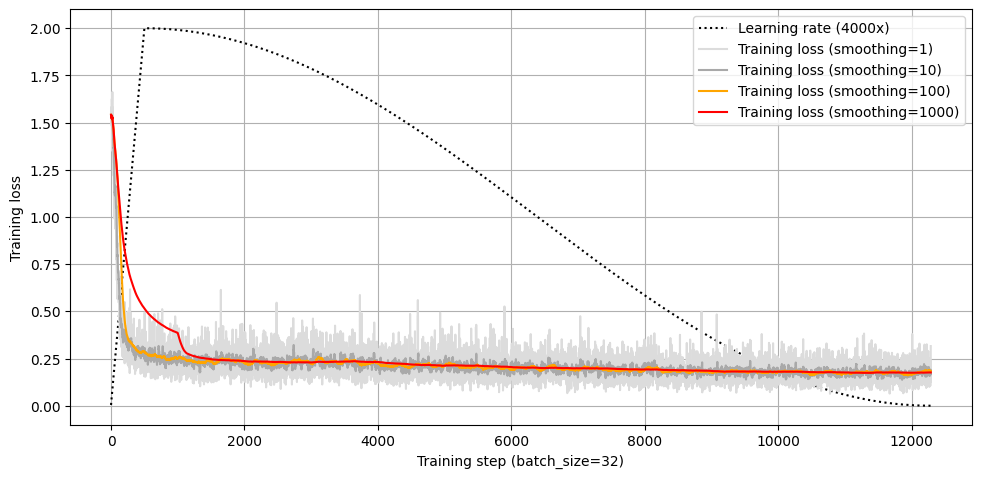

In [16]:
# config
plt.figure(figsize=(10, 5))
plt.grid(True)
plt.tight_layout(pad=2)
plt.xlabel(f"Training step (batch_size={batch_size})")
plt.ylabel("Training loss")
# learning rate
lr_factor = 4000
lr_rate_list_factor = [i*lr_factor for i in lr_rate_list]
plt.plot(lr_rate_list_factor, linestyle="dotted", color="black", label=f"Learning rate ({lr_factor}x)")
# smoothen loss_list and add according line to plot
colors = ["gainsboro", "darkgray", "orange", "red"]
for i, smoothing_n in enumerate([1, 10, 100, 1000]):
    smoothened_loss = smoothen_list(loss_list, smoothing_n)
    plt.plot(smoothened_loss, colors[i], label=f"Training loss (smoothing={smoothing_n})")
# legend
plt.legend(loc="upper right", shadow=False)
# save and show
plt.savefig(f"{output_dir}/training_loss_plot.png")
plt.show()

confusion_matrix saved under path:
ner_logs/FacebookAI-roberta-large/split=100__r=16__bias=all__loradroput=0point2/confusion_matrix_pct.png
confusion_matrix saved under path:
ner_logs/FacebookAI-roberta-large/split=100__r=16__bias=all__loradroput=0point2/confusion_matrix_abs.png


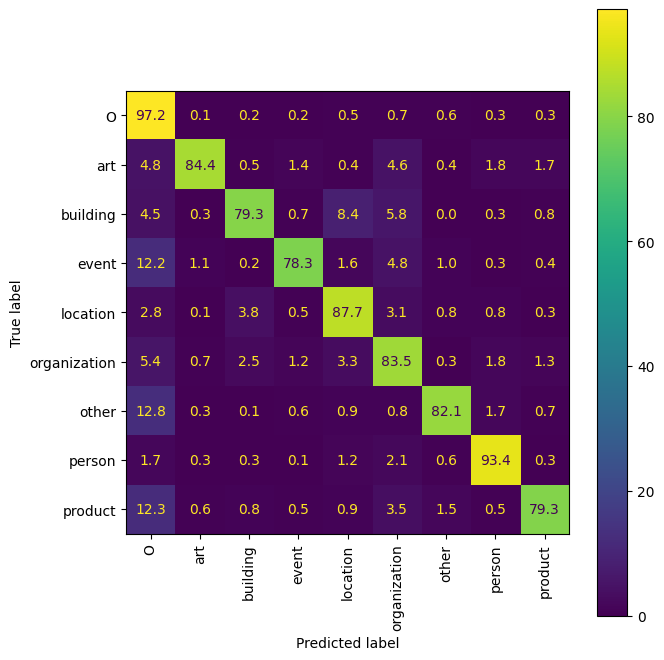

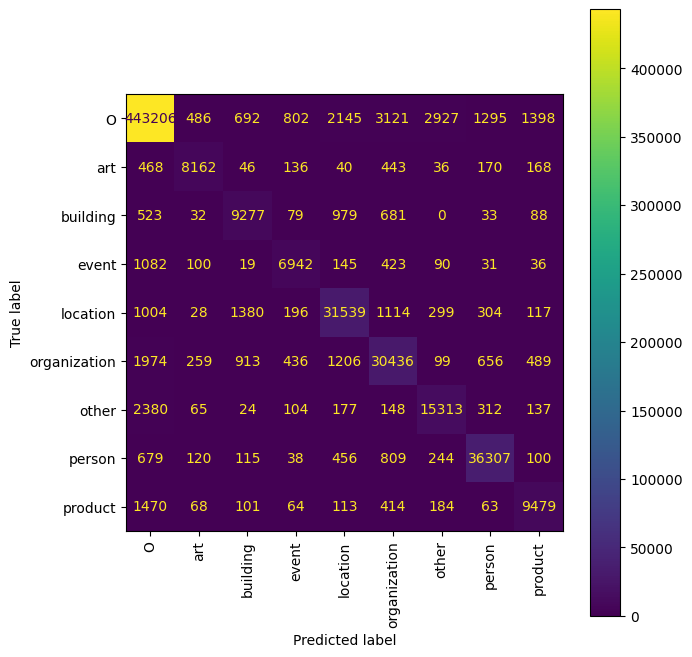

In [17]:
flat_epoch_labels_without_special_tokens = []
flat_epoch_predictions_without_special_tokens = []
for i in range(len(flat_epoch_labels)):
    label_i = flat_epoch_labels[i]
    prediction_i = flat_epoch_predictions[i]
    if label_i!=-100:
        flat_epoch_labels_without_special_tokens.append(label_i)
        flat_epoch_predictions_without_special_tokens.append(prediction_i)
# plot and save confusion matrices
for percentage in [True, False]:
    make_confusion_matrix(
        flat_epoch_labels_without_special_tokens,
        flat_epoch_predictions_without_special_tokens,
        label_names,
        percentage=percentage,
        output_dir=output_dir
    )

## Save logs and reload model for inference

In [18]:
with open(f"{output_dir}/logs_dict.json", "w") as outfile: 
	json.dump(logs_dict, outfile, indent=2)
logs_dict

{'seed': 42,
 'model_id': 'FacebookAI/roberta-large',
 'LoRA_params_dict': {'r': 16,
  'target_modules': ['query',
   'key',
   'value',
   'query_proj',
   'key_proj',
   'value_proj'],
  'bias': 'all',
  'use_rslora': True,
  'task_type': <TaskType.TOKEN_CLS: 'TOKEN_CLS'>,
  'lora_dropout': 0.2},
 'LoraConfig': "LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type=<TaskType.TOKEN_CLS: 'TOKEN_CLS'>, inference_mode=False, r=16, target_modules={'query_proj', 'key', 'query', 'value_proj', 'value', 'key_proj'}, lora_alpha=8, lora_dropout=0.2, fan_in_fan_out=False, bias='all', use_rslora=True, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={})",
 'LoRA_model_trainable_params': 2639881,
 'LoRA_model_all_params': 356687890,
 'LoRA_model_trainable_fraction': 0.0074,
 'tokenizer': 'F

In [19]:
# load inference model
config = PeftConfig.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained(output_dir)
inference_model = AutoModelForTokenClassification.from_pretrained(
    model_id,
    id2label=id2label,
    label2id=label2id,
    device_map="auto",
    load_in_8bit=True
)
inference_model = PeftModel.from_pretrained(inference_model, output_dir).merge_and_unload()
print(f"type(inference_model):\n{type(inference_model)}\n")
# get inputs from text (source: https://en.wikipedia.org/wiki/Konstanz#History)
text = "Konstanz was the birthplace of Count Ferdinand von Zeppelin, constructor of the famous Zeppelin airships."
inputs = tokenizer(text, return_tensors="pt")
inputs

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/matthias/.local/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:71: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(


type(inference_model):
<class 'transformers.models.roberta.modeling_roberta.RobertaForTokenClassification'>



{'input_ids': tensor([[    0, 11272, 22398,   329,    21,     5, 32357,     9, 12440, 28855,
          5689, 10915, 38042,     6, 47073,     9,     5,  3395, 10915, 38042,
           935, 31404,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [20]:
# inference
with torch.no_grad():
    logits = inference_model(**inputs).logits
tokens = inputs.tokens()
predictions = torch.argmax(logits, dim=2)
print(f"token (prediction)\n")
for token, prediction in zip(tokens, predictions[0].numpy()):
    print(f"{token} ({id2label[str(prediction)]})")

token (prediction)

<s> (O)
ĠKon (location)
stan (location)
z (location)
Ġwas (O)
Ġthe (O)
Ġbirthplace (O)
Ġof (O)
ĠCount (person)
ĠFerdinand (person)
Ġvon (person)
ĠZe (person)
ppelin (person)
, (O)
Ġconstructor (O)
Ġof (O)
Ġthe (O)
Ġfamous (O)
ĠZe (product)
ppelin (product)
Ġair (O)
ships (product)
. (O)
</s> (O)


$\checkmark$